<a href="https://colab.research.google.com/github/lucvseco/CNNsclassification/blob/main/CNNs_para_classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Usando CNNs para classificação



### 01 - Imports

In [ ]:
%%capture
!pip install torchsummary

In [ ]:
# modelagem e dados
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F

# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# outros
import zipfile
import os
import glob
import numpy as np

### 02 - Datasets e Dataloaders

O dataset utilizado para esse exemplo é CIFAKE: uma dataset com 120000 imagens com 50% sendo verdadeiras (provindas da dataset CIFAR-10) e 50% sendo geradas por Stable Diffusion (fakes).


In [ ]:
%%capture
!wget https://www.dropbox.com/scl/fi/fjto0e19s54c13ucezzch/cifake.zip?rlkey=s0b5diqzw5f8vguklapfnfsc6&dl=0

In [ ]:
def extract_file(src_file, dst_folder="cifake"):
  if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
  with zipfile.ZipFile(src_file, 'r') as zip_ref:
    zip_ref.extractall(dst_folder)

In [ ]:
filename = glob.glob("*.zip*")[0]
extract_file(filename)
os.remove(filename)

Usando o transforms.Compose definimos um conjunto de transformação que devem ser aplicadas no conjunto de treino e no conjunto de validação. (+10)

Transformações de treino:
- Transformar para tensor
- ColoJitter (b=.5, hue=.3)
- RandomRotation (0, 180)
- RandomHorizontalFlip (p=0.5)
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

Transformações da validação:
- Transormar para tensor
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

https://pytorch.org/vision/0.9/transforms.html

In [ ]:
# Adicionar transformacoes para treino e validacao

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_eval  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
def train_val_split(dataset, train_percentage=0.85):
    global transform, transform_eval
    length = len(dataset)
    indices = list(range(length))
    np.random.shuffle(indices)
    len_train = int(np.floor(train_percentage * length))
    train_idx, val_idx = indices[:len_train], indices[len_train:]
    return train_idx, val_idx

Criando os dataloaders para carregar os dados dos datasets gerados (train_ds, val_ds, test_ds) (+10)
- Criando os loaders utilizado batch=64 para treino e batch=128 para teste/validação
- usamos shuffle=True, num_workers=2 e pin_memory=True

In [ ]:

train_ds = datasets.ImageFolder(root="cifake/train", transform=transform_train)

val_ds = datasets.ImageFolder(root="cifake/train", transform=transform_eval)
train_idx, val_idx = train_val_split(train_ds)
train_ds = data.Subset(train_ds, train_idx)
val_ds = data.Subset(val_ds, val_idx)

test_ds = datasets.ImageFolder(root="cifake/test", transform=transform_eval)

In [ ]:
# Gera os dataloaders para iterar sobre os datasets

batch_size_train = 64
batch_size_eval = 128
num_workers = 2
pin_memory = True


train_dl = DataLoader(
    train_ds,
    batch_size=batch_size_train,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_dl   = DataLoader(
    val_ds,
    batch_size=batch_size_eval,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_dl  = DataLoader(
    test_ds,
    batch_size=batch_size_eval,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

## 03 - Visualizando os exemplos

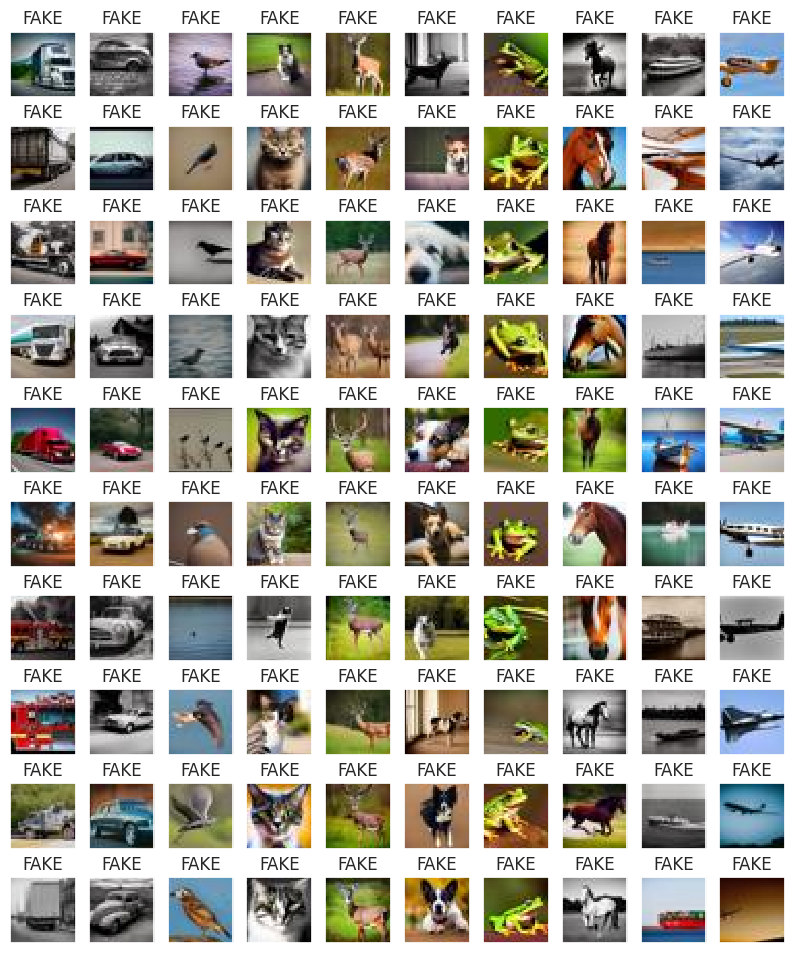

In [ ]:
instances, targets = next(iter(test_dl))

inv_norm = transforms.Normalize(
    mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std = [1 / 0.229, 1 / 0.224, 1 / 0.225]
)
ins = inv_norm(instances)

w = 10
fig, ax = plt.subplots(w, w, figsize=(10, 12))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(ins[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = int(targets[i * w + j].item())
    ax[i][j].set_title(test_ds.classes[label])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

## 04 - Gerando o modelo

Criando o modelo de classificação
Definindo a classe MyCNN que herda de nn.Module (+30)

a arquitetura,
 - nn.Sequential para gerar o modelo
 - Camadas:\
    - Conv2d: in_features=3, out_features=16, k=3
    - ReLU
    - Conv2d: in_features=16, out_features=32, k=3
    - ReLU
    - MaxPool2d: k=2, s=2
    - Conv2d: in_features=32, out_features=32, k=3
    - ReLU
    - Conv2d: in_features=32, out_features=32, k=3
    - ReLU
    - MaxPool2d: k=2, s=2
    - Flatten
    - Linear: out_features=256
    - ReLU
    - Dropot: p=0.5
    - Linear: out_features=256
    - ReLU
    - Dropout: p=0.5
    - Linear: out_features=1
    - Sigmoid

- use o `forward` para executar o modelo a partir do atributo Sequential

In [ ]:


class MyCNN(nn.Module):
  def __init__(self):
        super(MyCNN, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=32 * 8 * 8, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

  def forward(self, x):
      x = self.model(x)
      return x
  pass

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
classifier = MyCNN().to(device)

summary(classifier, input_size=(3,32,32), batch_size=64, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 16, 32, 32]             448
              ReLU-2           [64, 16, 32, 32]               0
            Conv2d-3           [64, 32, 32, 32]           4,640
              ReLU-4           [64, 32, 32, 32]               0
         MaxPool2d-5           [64, 32, 16, 16]               0
            Conv2d-6           [64, 32, 16, 16]           9,248
              ReLU-7           [64, 32, 16, 16]               0
            Conv2d-8           [64, 32, 16, 16]           9,248
              ReLU-9           [64, 32, 16, 16]               0
        MaxPool2d-10             [64, 32, 8, 8]               0
          Flatten-11                 [64, 2048]               0
           Linear-12                  [64, 256]         524,544
             ReLU-13                  [64, 256]               0
          Dropout-14                  [

## 05 - Treinamento

função de loss e o otimizador (+10)

- a loss BCE
- o otimizador ADAM (lr=1E-4)

https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):

  model.train()

  train_loss = AverageMeter()
  for sample, target in train_dl:
    sample = sample.to(device)
    target = target.to(device)

    optimizer.zero_grad()
    output = model(sample).flatten()
    loss = loss_fn(output, target.float())
    train_loss.update(loss.item(), len(sample))
    loss.backward()
    optimizer.step()
  return train_loss.avg

def validation_step(model, val_dl, loss_fn, device):
  model.eval()
  val_loss=AverageMeter()

  with torch.no_grad():
    for sample, target in val_dl:
      sample = sample.to(device)
      target = target.to(device)

      output = model(sample).flatten()
      loss = loss_fn(output, target.float())
      val_loss.update(loss.item(), len(sample))
  return val_loss.avg

In [ ]:
history_cs = {
    "train_loss": [],
    "val_loss": []
}

EPOCHS = 15

for epoch in range(EPOCHS):
  train_loss = train_step(classifier, train_dl, loss_fn, optimizer, device)
  val_loss   = validation_step(classifier, val_dl, loss_fn, device)

  history_cs["train_loss"].append(train_loss)
  history_cs["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")


Época [1/15]
-----------------------------------
Train loss: 0.538076
Valid. loss: 0.427813

Época [2/15]
-----------------------------------
Train loss: 0.421636
Valid. loss: 0.359051

Época [3/15]
-----------------------------------
Train loss: 0.383917
Valid. loss: 0.317332

Época [4/15]
-----------------------------------
Train loss: 0.363652
Valid. loss: 0.289737

Época [5/15]
-----------------------------------
Train loss: 0.347711
Valid. loss: 0.279614

Época [6/15]
-----------------------------------
Train loss: 0.336971
Valid. loss: 0.291042

Época [7/15]
-----------------------------------
Train loss: 0.328934
Valid. loss: 0.279658

Época [8/15]
-----------------------------------
Train loss: 0.318646
Valid. loss: 0.249768

Época [9/15]
-----------------------------------
Train loss: 0.30827
Valid. loss: 0.249314

Época [10/15]
-----------------------------------
Train loss: 0.305103
Valid. loss: 0.242447

Época [11/15]
-----------------------------------
Train loss: 0.297491

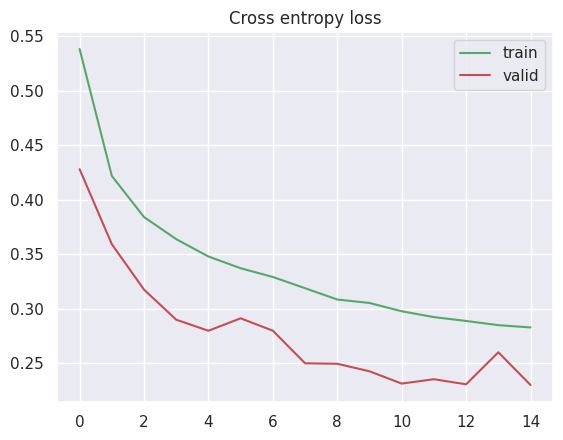

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history_cs["train_loss"], c="g", label="train")
plt.plot(history_cs["val_loss"], c="r", label="valid")
plt.legend()

## 06 - Tranfer Learning

utilizamos a resnet50 para realizar o transfer learning no dataset avaliado (+20)

- Usa a resnet50 do torch (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)
- inicializa o modelo com pesos no imagenet (ResNet50_Weights.IMAGENET1K_V2)
- congela os parameteros da arquitetura (requires_grad=False)
- definir um classficador usando nn.Sequential
  - O classificador deve conter as camadas: Linear(resnet50.fc.in_features, 256), ReLU(), Linear(256, 1), Sigmoid()
- atribua o classficador em resnet50.fc
- transfira o modelo para o device do ambiente

In [ ]:
weights = ResNet50_Weights.IMAGENET1K_V2
resnet50 = resnet50(weights=weights)

for param in resnet50.parameters():
    param.requires_grad = False

classificador = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

resnet50.fc = classificador

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

classifier_tl = resnet50

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


In [ ]:
device_str = str(device)
summary(classifier_tl, input_size=(3, 224, 224), batch_size=64, device=device_str)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,408
       BatchNorm2d-2         [64, 64, 112, 112]             128
              ReLU-3         [64, 64, 112, 112]               0
         MaxPool2d-4           [64, 64, 56, 56]               0
            Conv2d-5           [64, 64, 56, 56]           4,096
       BatchNorm2d-6           [64, 64, 56, 56]             128
              ReLU-7           [64, 64, 56, 56]               0
            Conv2d-8           [64, 64, 56, 56]          36,864
       BatchNorm2d-9           [64, 64, 56, 56]             128
             ReLU-10           [64, 64, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]          16,384
      BatchNorm2d-12          [64, 256, 56, 56]             512
           Conv2d-13          [64, 256, 56, 56]          16,384
      BatchNorm2d-14          [64, 256,

Usando o transforms.Compose definimos um conjunto de transformação que devem ser aplicadas no conjunto de treino e no conjunto de validação. (+10)

Transformações de treino:
- Resize (224)
- Transformar para tensor
- ColorJitter (b=.5, hue=.3)
- RandomRotation (0, 180)
- RandomHorizontalFlip (p=0.5)
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

Transformações da validação:
- Resize (224)
- Transormar para tensor
- Normalize (mean=[.485,.456,.406], std=[.229,.224,.225])

https://pytorch.org/vision/0.9/transforms.html

In [ ]:
transform_train_tl = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_eval_tl = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
train_dl.dataset.transform = transform_train_tl
val_dl.dataset.transform   = transform_eval_tl

o loss (BCE) e o otimizador com os parâmetros do novo modelo (+10)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_tl.parameters()), lr=1e-4)

In [ ]:
N_EPOCHS_TL = 15

history_tl = {
    "train_loss": [],
    "val_loss": []
}

for epoch in range(N_EPOCHS_TL):
  train_loss = train_step(classifier_tl, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(classifier_tl, val_dl, loss_fn, device)

  history_tl["train_loss"].append(train_loss)
  history_tl["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{N_EPOCHS_TL}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/15]
-----------------------------------
Train loss: 0.603512
Valid. loss: 0.561814

Época [2/15]
-----------------------------------
Train loss: 0.57666
Valid. loss: 0.551681

Época [3/15]
-----------------------------------
Train loss: 0.568735
Valid. loss: 0.541948

Época [4/15]
-----------------------------------
Train loss: 0.566885
Valid. loss: 0.540872

Época [5/15]
-----------------------------------
Train loss: 0.560125
Valid. loss: 0.543651

Época [6/15]
-----------------------------------
Train loss: 0.559416
Valid. loss: 0.540894

Época [7/15]
-----------------------------------
Train loss: 0.557636
Valid. loss: 0.526565

Época [8/15]
-----------------------------------
Train loss: 0.555751
Valid. loss: 0.526359

Época [9/15]
-----------------------------------
Train loss: 0.553545
Valid. loss: 0.529777

Época [10/15]
-----------------------------------
Train loss: 0.553127
Valid. loss: 0.533831

Época [11/15]
-----------------------------------
Train loss: 0.553313

## 07 - Testando arquitetura propria (MyCNN)

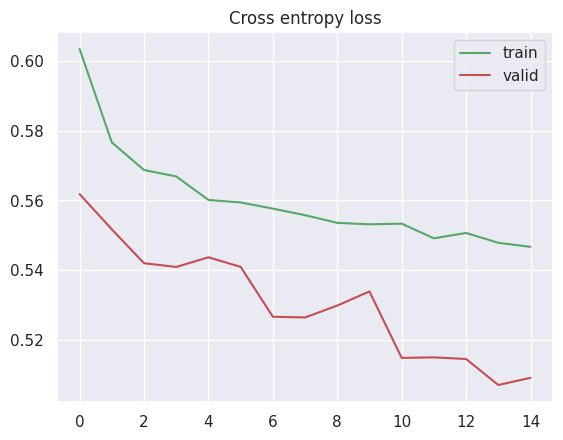

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history_tl["train_loss"], c="g", label="train")
plt.plot(history_tl["val_loss"], c="r", label="valid")
plt.legend()

In [ ]:
test_dl.dataset.transform = transform_eval
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        preds = classifier(test_instances)
    preds[preds > 0.5] = 1.0
    preds[preds < 0.5] = 0.0

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))

preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

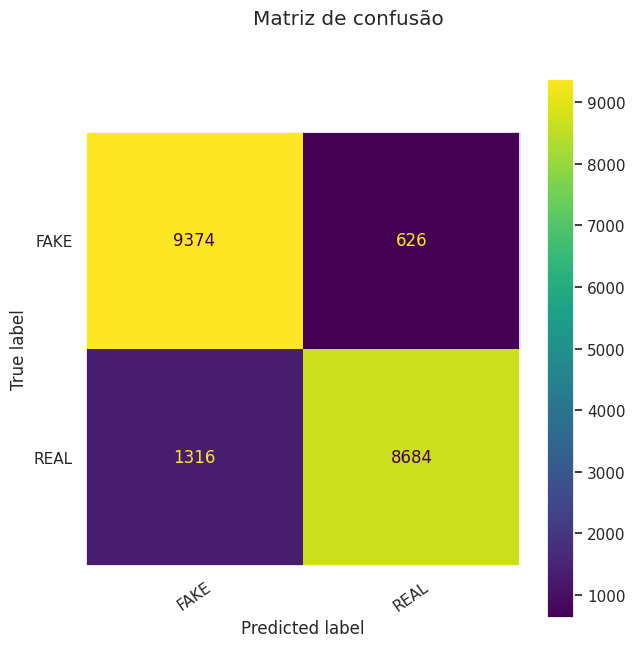

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [ ]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.88      0.94      0.91     10000
        REAL       0.93      0.87      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

